# Histogram Sampling of Airborne Lidar Overlap Regions

Idea: 
1. Open some number of potentially overlapping scans at the same time and coarsely sample them. 
2. Find points that overlap with another flight. 
3. Add these points to a 3D histogram to denote overlap regions. 
4. Collect all points in bins with points that have many neighbors

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pandas as pd
from pathlib import Path
from pptk import kdtree
from tqdm import tqdm, trange

In [22]:
# Some options to play with
sample_overlap_size = int(10e3)
pc1_path = '1'
pc2_path = '3' 

# Some examples of various types of overlap
# 1 and 10 - 1 is bisected by 10
# 1 and 37 - 1 and 37 are parallel with small overlap
# 1 and 3  - 1 and 3 are parallel with no overlap


In [23]:
# Get our point clouds ready to load in 
pc_dir = Path("../dublin/npy/")
pc_paths = {f.stem:f.absolute() for f in pc_dir.glob("*.npy")}
print(pc_paths.keys())
# pc = np.load(pc_paths['num'])

dict_keys(['26', '29', '37', '3', '21', '30', '22', '17', '9', '33', '14', '10', '11', '4', '25', '2', '40', '8', '16', '12', '35', '23', '5', '34', '36', '24', '31', '28', '20', '27', '7', '13', '15', '0', '38', '19', '6', '39', '1', '18', '32'])


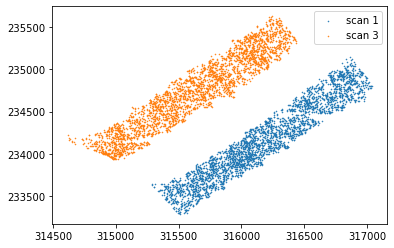

In [24]:
# Initial visualization of our point clouds to visually check for overlap
pc1 = np.load(pc_paths[pc1_path])
pc2 = np.load(pc_paths[pc2_path])
pc1_vis_s = pc1[np.random.choice(len(pc1), size=3000, replace=False)]
pc2_vis_s = pc2[np.random.choice(len(pc2), size=3000, replace=False)]

plt.scatter(pc1_vis_s[:, 0], pc1_vis_s[:, 1], s=0.3, label=f"scan {pc1_path}")
plt.scatter(pc2_vis_s[:, 0], pc2_vis_s[:, 1], s=0.3, label=f"scan {pc2_path}")

plt.legend()
plt.show()

In [25]:
def get_hist_overlap(pc1, pc2, sample_overlap_size=10000, hist_bin_length=10):
    # Params:
    #     pc1: point cloud 1 (np array with shape ([m, k1]))
    #     pc2: point cloud 2 (np array with shape ([n, k2]))
    #
    # k1 and k2 must contain at least x and y coordinates. 
    
    #
    # Returns:
    #     
    
    # define a data range
    pc_combined = np.concatenate((pc1, pc2))
    data_range = np.array(
        [[pc_combined[:, 0].min(), pc_combined[:, 0].max()],
        [pc_combined[:, 1].min(), pc_combined[:, 1].max()],
        [pc_combined[:, 2].min(), pc_combined[:, 2].max()]])

    del pc_combined  # save some mem
    
    # define bins based on data_range:
    x_bins = int((data_range[0][1]-data_range[0][0])/10)
    y_bins = int((data_range[1][1]-data_range[1][0])/10)
    z_bins = int((data_range[2][1]-data_range[2][0])/10)
    
    # Collect some number of points as overlap between these point clouds
    # build kd tree so we can search for points in pc2
    kd = kdtree._build(pc2[:, :3])

    # collect a sample of points in pc1 to query in pc2
    sample_overlap = np.random.choice(len(pc1), size=sample_overlap_size)
    pc1_sample = pc1[sample_overlap]

    # query pc1 sample in pc2. note that we want lots of nearby neighbors
    query = kdtree._query(kd, pc1_sample[:, :3], k=150, dmax=1)
    
    # Count the number of neighbors found at each query point
    counts = np.zeros((len(query), 1))
    for i in range(len(query)):
        counts[i][0] = len(query[i])

    # Append this to our sample
    pc1_sample_with_counts = np.concatenate((pc1_sample[:, :3], counts), axis=1)

    # this needs to be transformed such that the points (X, Y) occur in the
    # array `count` times. This will make histogram creation easier.
    rows = []
    for i in range(len(pc1_sample_with_counts)):
        row = pc1_sample_with_counts[i, :3]
        row = np.expand_dims(row, 0)
        if pc1_sample_with_counts[i, 2]:
            duplication = np.repeat(row, pc1_sample_with_counts[i, 3], axis=0)
            rows.append(duplication)
    
    pc1_sample_f = np.concatenate(rows, axis=0)
    
    # build histogram over data
    hist, edges = np.histogramdd(
        pc1_sample_f[:, :3], 
        bins=[x_bins, y_bins, z_bins],
        range=data_range)

    return (hist, edges), pc1_sample_f

In [26]:
def visualize_hist(pc1, pc2, overlap_sample):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005
    
    pc_combined = np.concatenate((pc1, pc2))
    data_range = np.array(
        [[pc_combined[:, 0].min(), pc_combined[:, 0].max()],
        [pc_combined[:, 1].min(), pc_combined[:, 1].max()]])
    
    x_bins = int((data_range[0][1]-data_range[0][0])/10)
    y_bins = int((data_range[1][1]-data_range[1][0])/10)

    del pc_combined  # save some mem

    fig, ax = plt.subplots(figsize=(17, 12))
    
    vs1 = np.random.choice(len(pc1), size=5000, replace=False)
    vs2 = np.random.choice(len(pc2), size=5000, replace=False)
    ax.scatter(pc1[vs1, 0], pc1[vs1, 1], s=10, label=f"scan 1")
    ax.scatter(pc2[vs2, 0], pc2[vs2, 1], s=10, label=f"scan 2")
    
    ax.set_title("Histogram of Overlap Region")

    hist, xedges, yedges, qm = ax.hist2d(
        overlap_sample[:, 0], 
        overlap_sample[:, 1], 
        bins=[x_bins, y_bins], 
        range=data_range,
        density=True,
        norm=colors.LogNorm())

    ax.legend()
    plt.show()

In [27]:
%%time
# Visualize this data
hist_info, overlap_sample = get_hist_overlap(pc1, pc2)
# visualize_hist(pc1, pc2, overlap_sample)
hist, edges = hist_info
print(hist.shape)

(253, 236, 44)
CPU times: user 10.7 s, sys: 743 ms, total: 11.5 s
Wall time: 3.91 s


In [28]:
def get_overlap_points(pc, hist_info, c):
    # this seems slow
    a = np.empty(shape=(0, 9))
    hist, (xedges, yedges, zedges) = hist_info
    indices = np.zeros(pc.shape[0])
    for i in range(hist.shape[0]):
        for j in range(hist.shape[1]):
            for k in range(hist.shape[2]):
                if hist[i][j][k] > c:
                    x1, x2 = xedges[i], xedges[i+1]
                    y1, y2 = yedges[j], yedges[j+1]
                    z1, z2 = zedges[k], zedges[k+1]
                    
                    new_indices = ((x1 <= pc[:, 0]) & (pc[:, 0] < x2) & 
                        (y1 <= pc[:, 1]) & (pc[:, 1] < y2) &
                        (z1 <= pc[:, 2]) & (pc[:, 2] < z2))
                    
                    indices = indices | new_indices
                    
                    points = pc1[
                        (x1 <= pc[:, 0]) & (pc[:, 0] < x2) & 
                        (y1 <= pc[:, 1]) & (pc[:, 1] < y2) &
                        (z1 <= pc[:, 2]) & (pc[:, 2] < z2)
                    ]

                    a = np.concatenate((a, points))

    return a, indices             

In [29]:
%%time
pc_overlap = get_overlap_points(pc1, hist_info, 100)
print(f"Filtered out {(100*(pc1.shape[0]-pc_overlap.shape[0])/(pc1.shape[0])):.2f}% of points")

Filtered out 100.00% of points
CPU times: user 1.23 s, sys: 283 µs, total: 1.23 s
Wall time: 1.23 s


(0, 9)


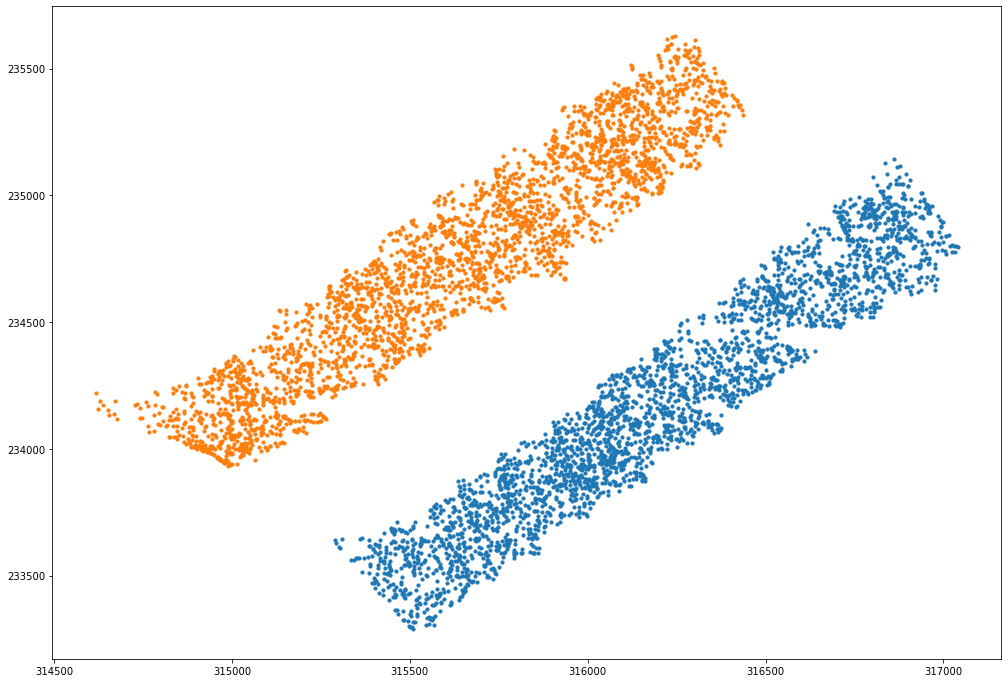

In [32]:
print(pc_overlap.shape)
fig, ax = plt.subplots(figsize=(17, 12))

ax.scatter(pc1_vis_s[:, 0], pc1_vis_s[:, 1], s=10)
ax.scatter(pc2_vis_s[:, 0], pc2_vis_s[:, 1], s=10)
ax.scatter(pc_overlap[:, 0], pc_overlap[:, 1], s=10, c='tab:red')

plt.show()

(0, 9)
0.0


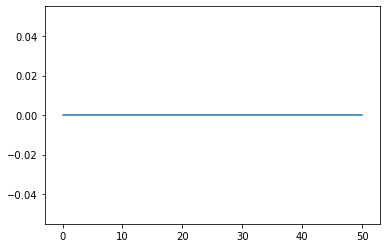

In [31]:
# build dataset with balanced coverage across the target range of intensities

# pc_overlap contains points from pc1, and each intensity is a 'target' intensity
# just query the target intensities we want and then find neighborhoods with kdtree._query

# subdivide target intensities into groups of 5 (103 total) and then sample pc_overlap for those ranges. 
print(pc_overlap.shape)

groups = np.arange(0, 520, 10)

dataset = []
x = []
height = []
for i in range(len(groups)-1):
    sample = pc_overlap[(pc_overlap[:, 3] >= groups[i]) & (pc_overlap[:, 3] < groups[i]+1)]
    x.append(i)
    height.append(sample.shape[0])

m = np.array(height).mean()
print(m)

plt.bar(x, height)
plt.plot(np.linspace(0, 50), np.repeat(m, 50))
plt.show()
